In [1]:
import random
import csv
import os
import pickle

import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from matplotlib import pyplot as plt
import sys

from tqdm import tqdm

from utils.misc.misc import shuffle_lists_by_group
from utils.training.metrics import accuracy_for_segmenter
from utils.training.data_loading import lines_to_line_generator_waveform, get_line_to_dataset_waveform
from utils.training.keras_models import phasenet_like_model

2023-11-15 15:55:31.337871: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 15:55:31.398127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 15:55:31.398177: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 15:55:31.398445: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-15 15:55:31.420280: I tensorflow/core/platform/cpu_feature_g

In [2]:
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/training/waveforms"
SEED = 0
BATCH_SIZE = 32
EPOCHS = 50
CHECKPOINTS_DIR = "checkpoints_seg_waveforms"

FOLDS = 5
SIZE = int(2**(np.ceil(np.log2(100*240+1))))  # number of points in each file rounded to the next pow of 2
DURATION_S = 100  # duration of the files in s
OBJECTIVE_CURVE_WIDTH = 10  # defines dispersion of objective function in s

data_loader = get_line_to_dataset_waveform(size=SIZE, duration_s=DURATION_S, objective_curve_width=OBJECTIVE_CURVE_WIDTH)
model = phasenet_like_model

In [3]:
# open the csv listing data, shuffling the lines
with open(ROOT_DIR + "/dataset.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    lines = list(csv_reader)
random.Random(SEED).shuffle(lines)
print(len(lines), "files found")

TO_KEEP = 2000

# load data
pos = [l for l in lines if l[1]=="positive"][:TO_KEEP]
xpos, ypos = data_loader(pos)
neg = [l for l in lines if l[1]=="negative"][:TO_KEEP]
xneg, yneg = data_loader(neg)
del pos, neg
print(f"{len(xpos)} positive files found and {len(xneg)} negative files found")

# merge and shuffle positives and negatives
xd = np.concatenate((xpos, xneg[:len(xpos)]))
extra_x = xneg[len(xpos):]
del xneg, xpos
yd = np.concatenate((ypos, yneg[:len(ypos)]))
extra_y = yneg[len(ypos):]
del yneg, ypos
shuffle_lists_by_group([(xd, yd)], SEED)

33919 files found


100%|██████████| 2000/2000 [00:03<00:00, 582.31it/s]


2000 positive files found and 2000 negative files found


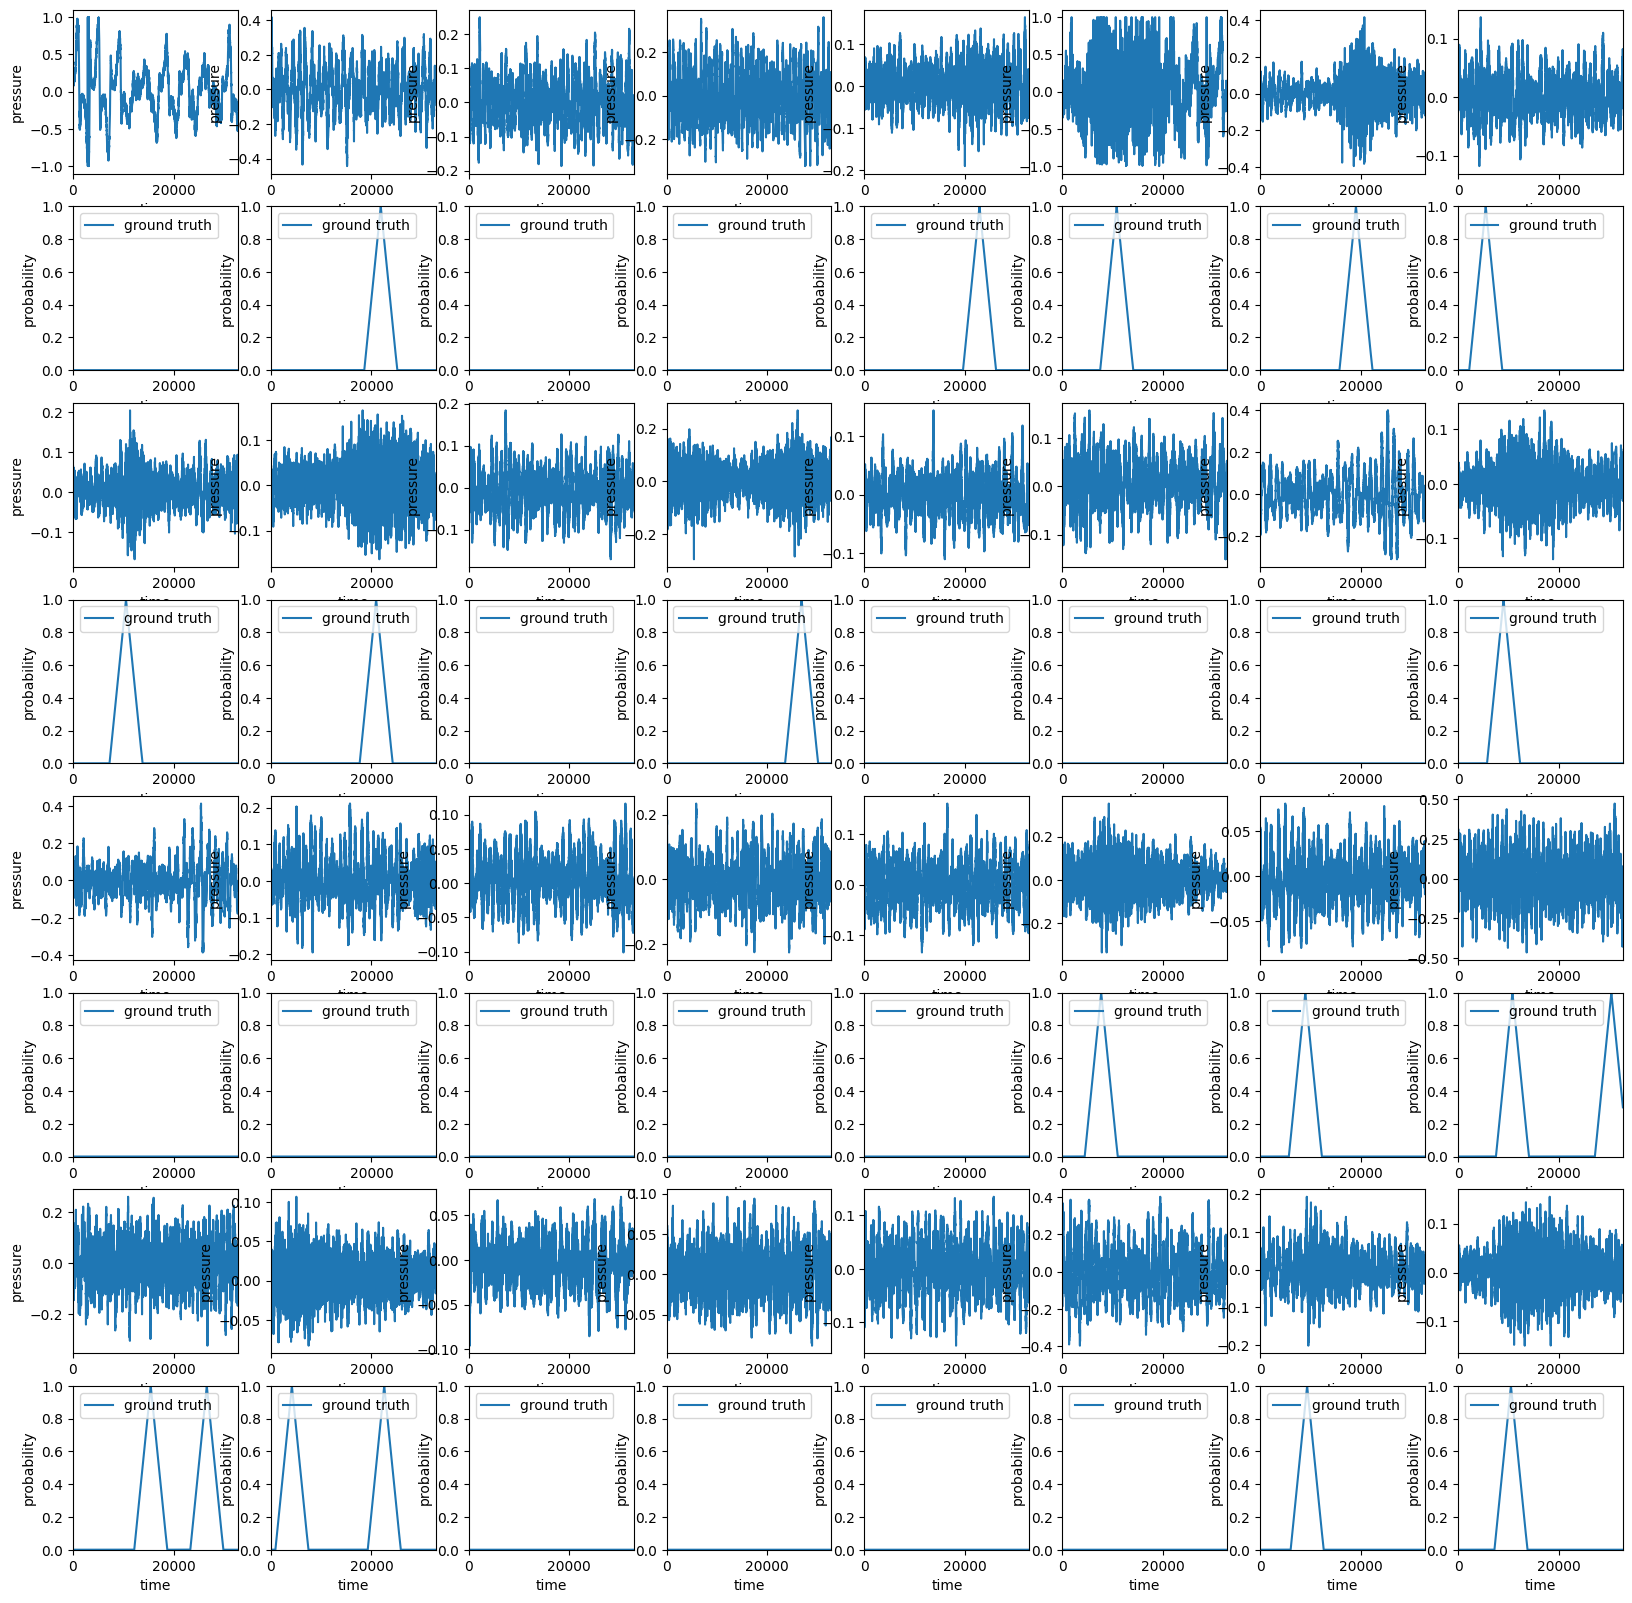

In [4]:
cols = 8
lines = 4
to_skip = 0

to_show = cols * lines
to_skip *= to_show
plt.figure(figsize=(cols*2.5, lines*5))
shown=0
for i in range(to_skip, to_skip+to_show):
    x, y = xd[i], yd[i]
    
    ax1 = plt.subplot(lines*2, cols, 1 + shown%cols + cols*2*(shown//cols))
    plt.xlabel("time")
    plt.ylabel("pressure")
    plt.plot(x)
    ax1.set_xlim([0, SIZE])

    ax2 = plt.subplot(lines*2, cols, 1 + shown%cols + cols*2*(shown//cols) + cols)

    ax2.plot(y, label='ground truth')
    ax2.legend(loc="upper left")
    ax2.set_xlim([0, SIZE])
    ax2.set_ylim([0, 1])
    ax2.set_xlabel("time")
    ax2.set_ylabel("probability")

    shown += 1
plt.show()

In [9]:
def phasenet_like_model():
    inputs = layers.Input(shape=(SIZE,))
    
    x = layers.Reshape((SIZE, 1))(inputs)

    x = layers.Conv1D(8, 7, padding='same', activation='relu')(x)
    x1 = layers.Conv1D(8, 7, padding='same', activation='relu')(x)
    x = layers.Conv1D(8, 7, padding='same', strides=4, activation='relu')(x1)
    x2 = layers.Conv1D(11, 7, padding='same', activation='relu')(x)
    x = layers.Conv1D(11, 7, padding='same', strides=4, activation='relu')(x2)
    x3 = layers.Conv1D(16, 7, padding='same', activation='relu')(x)
    x = layers.Conv1D(16, 7, padding='same', strides=4, activation='relu')(x3)
    x4 = layers.Conv1D(22, 7, padding='same', activation='relu')(x)
    x = layers.Conv1D(22, 7, padding='same', strides=4, activation='relu')(x4)
    x5 = layers.Conv1D(29, 7, padding='same', activation='relu')(x)
    x = layers.Conv1D(29, 7, padding='same', strides=4, activation='relu')(x5)
    x6 = layers.Conv1D(37, 7, padding='same', activation='relu')(x)
    x = layers.Conv1D(37, 7, padding='same', strides=4, activation='relu')(x6)

    x = layers.Conv1D(46, 4, padding='same', activation='relu')(x)
    
    x = layers.Conv1DTranspose(37, 7, padding='same', strides=4, activation='relu')(x)
    x = layers.concatenate([x6, x])
    x = layers.Conv1D(37, 7, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(29, 7, padding='same', strides=4, activation='relu')(x)
    x = layers.concatenate([x5, x])
    x = layers.Conv1D(29, 7, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(22, 7, padding='same', strides=4, activation='relu')(x)
    x = layers.concatenate([x4, x])
    x = layers.Conv1D(22, 7, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(16, 7, padding='same', strides=4, activation='relu')(x)
    x = layers.concatenate([x3, x])
    x = layers.Conv1D(16, 7, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(11, 7, padding='same', strides=4, activation='relu')(x)
    x = layers.concatenate([x2, x])
    x = layers.Conv1D(11, 7, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(8, 7, padding='same', strides=4, activation='relu')(x)
    x = layers.concatenate([x1, x])
    x = layers.Conv1D(8, 7, padding='same', activation='relu')(x)
    x = layers.Conv1D(1, 7, padding='same', activation='sigmoid')(x)
    
    outputs = layers.Flatten()(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="phasenet_like")

    return model

model = phasenet_like_model

In [ ]:
for i in range(FOLDS):
    path_prefix = f'{CHECKPOINTS_DIR}/FOLD-{i}'
    history_file = f'{path_prefix}/history.pkl'
    
    if os.path.isfile(history_file):
        print(f"fold {i} already has an history file, skipping it")
        continue
        
    print(f"starting training of fold {i}")
    m = model()
    m.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss=tf.losses.binary_crossentropy,
            metrics=accuracy_for_segmenter)
    m.build((BATCH_SIZE, SIZE))

    if i==0:
        m.summary()

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{path_prefix}/cp-{{epoch:04d}}.ckpt', save_weights_only=True, verbose=1)

    # make fold
    start_valid_idx = int(len(xd) * i / FOLDS)
    end_valid_idx = int(len(xd) * (i + 1) / FOLDS)
    
    x_train = np.concatenate((xd[:start_valid_idx], xd[end_valid_idx:]))
    y_train = np.concatenate((yd[:start_valid_idx], yd[end_valid_idx:]))
    
    x_valid = xd[start_valid_idx:end_valid_idx]
    y_valid = yd[start_valid_idx:end_valid_idx]
    
    shuffle_lists_by_group([(x_train, y_train), (x_valid, y_valid)], SEED)
    y_train = np.reshape(y_train, (-1, SIZE))
    y_valid = np.reshape(y_valid, (-1, SIZE))

    history = m.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            validation_data=(x_valid,y_valid),
            epochs=EPOCHS,
            callbacks=[cp_callback]
        )
    
    with open(history_file, 'wb') as f:
        pickle.dump(history.history, f)

starting training of fold 0
Model: "phasenet_like"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32768)]              0         []                            
                                                                                                  
 reshape_2 (Reshape)         (None, 32768, 1)             0         ['input_3[0][0]']             
                                                                                                  
 conv1d_42 (Conv1D)          (None, 32768, 8)             64        ['reshape_2[0][0]']           
                                                                                                  
 conv1d_43 (Conv1D)          (None, 32768, 8)             456       ['conv1d_42[0][0]']           
                                                          

In [8]:
all_train_x, all_train_y = np.concatenate((xd, extra_x)), np.concatenate((yd, extra_y))
shuffle_lists_by_group([(all_train_x, all_train_y)], 0)

m = model()

m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss=tf.losses.binary_crossentropy,
        metrics=accuracy_for_segmenter)

m.build((BATCH_SIZE, SIZE))

m.summary()

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{CHECKPOINTS_DIR}/cp-{{epoch:04d}}.ckpt",
                                                     save_weights_only=True,
                                                     verbose=1)



m.fit(
        all_train_x, all_train_y,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[cp_callback]
    )

Model: "phasenet_like"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32768)]              0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 32768, 1)             0         ['input_2[0][0]']             
                                                                                                  
 conv1d_21 (Conv1D)          (None, 32768, 8)             64        ['reshape_1[0][0]']           
                                                                                                  
 conv1d_22 (Conv1D)          (None, 32768, 8)             456       ['conv1d_21[0][0]']           
                                                                                      


KeyboardInterrupt



In [ ]:
m.load_weights(f"{CHECKPOINTS_DIR}/FOLD-0/cp-0025.ckpt")

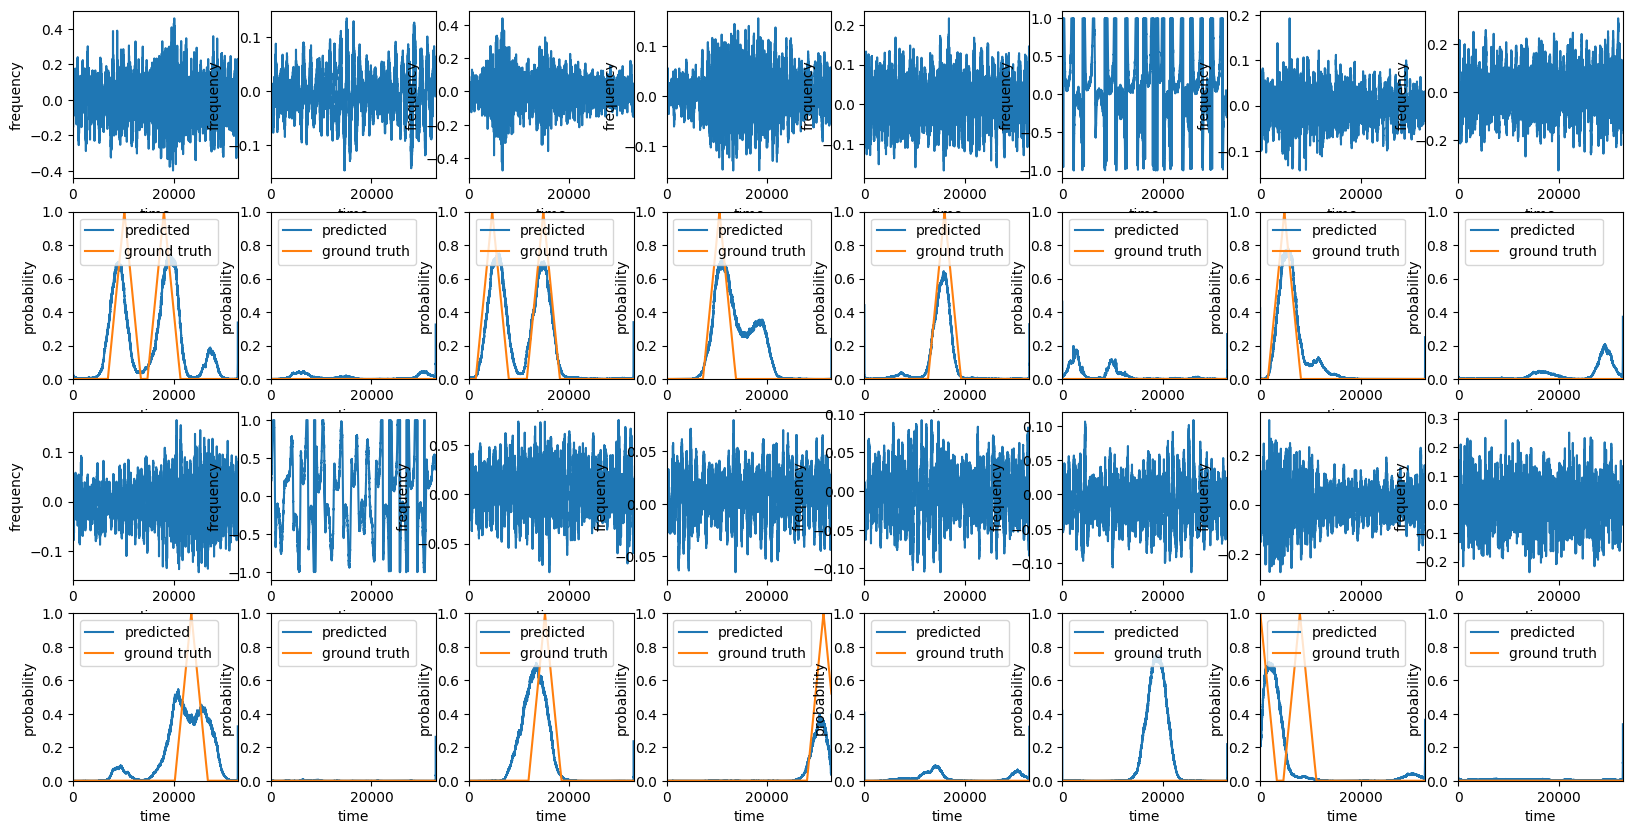

In [7]:
cols = 8
lines = 2
to_skip = 2

to_show = cols * lines
to_skip *= to_show
plt.figure(figsize=(cols*2.5, lines*5))
shown=0
for i in range(to_skip, to_skip+to_show):
    x, y = xd[i], yd[i]
    
    ax1 = plt.subplot(lines*2, cols, 1 + shown%cols + cols*2*(shown//cols))
    plt.xlabel("time")
    plt.ylabel("frequency")
    plt.plot(x)
    ax1.set_xlim([0, SIZE])

    ax2 = plt.subplot(lines*2, cols, 1 + shown%cols + cols*2*(shown//cols) + cols)
    
    predicted = m.predict(np.reshape(x, (1, SIZE)), verbose=False)[0]
    ax2.plot(predicted, label='predicted')
    ax2.plot(y, label='ground truth')
    ax2.legend(loc="upper left")
    ax2.set_xlim([0, SIZE])
    ax2.set_ylim([0, 1])
    ax2.set_xlabel("time")
    ax2.set_ylabel("probability")

    shown += 1
plt.show()